# Metodi di Smoothing per TSF

> (c) 2025 Antonio Michele Piemontese
>

Lo smoothing è basato sull'**averaging** dei valori della serie nel tempo (in un dato numero di *periodi*) per cercare di **ridurre il rumore**.<br>
Vedremo qui due *semplici* smoother: **moving average** e **exponential smoothing**.<br>
Entrambi sono adatti per TSF di serie <u>senza</u> trend e stagionalità.<br>
In entrambi i casi, i **forecast** sono appunto MEDIE dei valori precedenti della serie. I metodi *moving average* utilizzano il parametro **ampiezza** (*width*), i metodi *exponential smoothing* utilizzano il parametro **pesi** (*weights*).<br>

A differenza del metodo di TSF della regressione, che è parametrico, i metodi di TSF di smoothing sono **non-parametrici**, cioè non c'è modello, non ci sono assunzioni, ed i metodi si adattano <u>direttamete</u> ai dati (metodi *data-driven*), anche se mutevoli nel tempo.<br>
Lo **scopo** dello smoothing è di eliminare (*smooth out*) il rumore della serie, per cercare di scoprire i **pattern**.


# I package richiesti

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing # <--- NUOVO (rispetto agli altri notebook)

import dmba

%matplotlib inline


In [2]:
# la definizione delle due funzioni grafiche introdotte nello script C) e che qui riuseremo.

# Creazione del grafico 
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()
    xlim = (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), 
            max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
    axes[0].set_xlim(*xlim)
    axes[1].set_xlim(*xlim)

# Moving average
Questi metodi fanno l'*averaging* della serie su una finestra di *periodi* consecutivi.<br>
Il parametro *w* (l'ampiezza della finestra) definisce il numero di periodi successivi sui quali si fa *averaging*.<br>
Due tipi: 
* **centrato**: adatto per la *data visualization* perchè l'averaging (centrato) può eliminare trend e stagionalità, evidenziando i pattern;
* **trailing**: adatto anche per TSF.<br>

La differenza tra i due metodi sta nel <u>posizionamento</u> della finestra sulla serie. [Il valore della MA al periodo *t*](Centered_MA.png).<br>

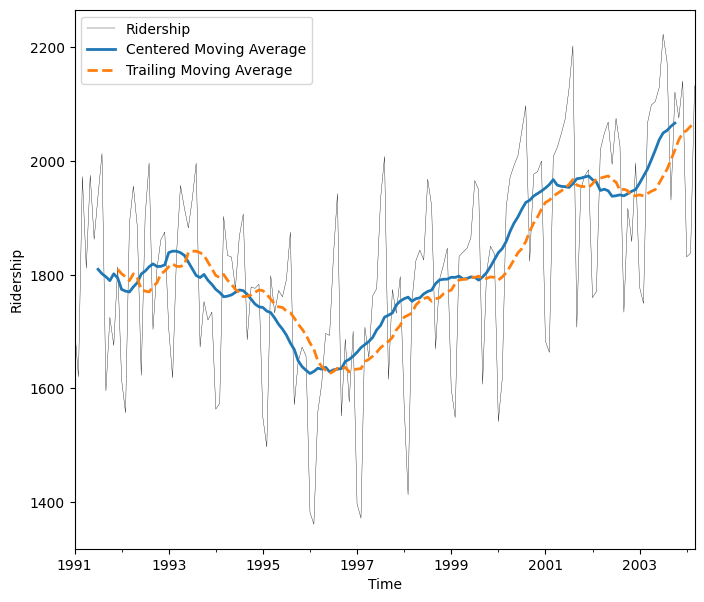

In [3]:
# usiamo nuovamente l'ottima serie 'Amtrak' (viaggiatori in treno).
# facciamo 'data visualization' (cioè vogliamo capire, esplorare) con entrambi i metodi MA (Moving Average=Media Mobile):

Amtrak_df = dmba.load_data('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

# La scelta di *w* (per MA centrato) in una serie con stagionalità (come Amtrak) è facile: lo scopo è sopprimere 
# la stagionalità (per evidenziare il trend) e dunque 'w ottimale' è la lunghezza del ciclo stagionale
# [per amtrak w=12].

# moving average centrato con finestra = 12 mesi
ma_centered = ridership_ts.rolling(12, center=True).mean()

# trailing moving average con finestra = 12
ma_trailing = ridership_ts.rolling(12).mean() # genera il "forecast" per feb-92 e ss. in base all'ultima MA nel periodo 
                                              # di "training" (gen-92) [w=12].
                                              # "forecast" e "training" tra virgolette perchè non si sono ancora
                                              # partizionati i dati.

# shift dell'average di una unità (12 mesi):
# ma_centered = pd.Series(ma_centered[:-1].values, index=ma_centered.index[1:])
# ma_trailing = pd.Series(ma_trailing[:-1].values, index=ma_trailing.index[1:])

fig, ax = plt.subplots(figsize=(8, 7))
ax = ridership_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_centered.plot(ax=ax, linewidth=2)
ma_trailing.plot(ax=ax, style='--', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership')
ax.legend(['Ridership', 'Centered Moving Average', 'Trailing Moving Average'])

plt.show()            # --> una forma ad U;
                      #     chiaramente MA centrato inizia prima (a metà 1991), mentre MA trailing inizia ad inizio 1992
                      #     a motivo delle definizioni viste prima. 
                      # --> forma molto simile, a parte lo shift, dovuto al tipo di finestra

C:\Users\Utente\AppData\Local\Temp\ipykernel_15088\2127913788.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_ma = ma_trailing[-1]


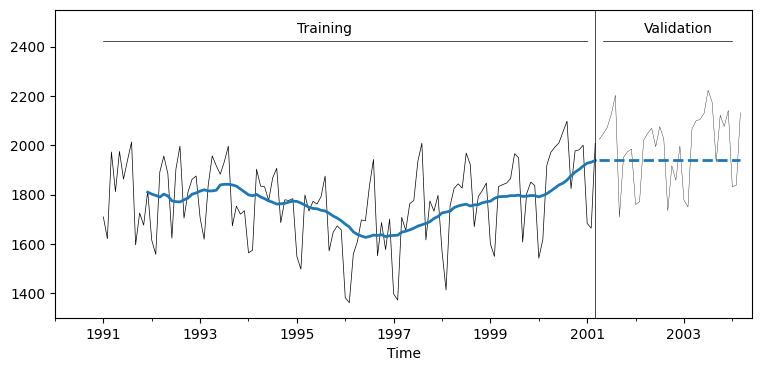

In [4]:
# le medie (=average) di 'centered MA' sono fatte rispetto ai dati passati e futuri (al periodo t). Ma nel TSF il futuro 
# NON è noto per definizione, e dunque centered MA non può essere usato per TSF.

# vediamo allora il trailing MA per TSF.
# la finestra w, nel trailing MA, è definita sugli ULTIMI w periodi disponibili.

# partizionamento dei dati:
nValid = 36
nTrain = len(ridership_ts) - nValid

train_ts = ridership_ts[:nTrain]
valid_ts = ridership_ts[nTrain:]

# moving average trailing sul training set:
ma_trailing = train_ts.rolling(12).mean()  # finestra w=12
last_ma = ma_trailing[-1]              
ma_trailing_pred = pd.Series(last_ma, index=valid_ts.index)

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_trailing.plot(ax=ax, linewidth=2, color='C0')
ma_trailing_pred.plot(ax=ax, style='--', linewidth=2, color='C0')
singleGraphLayout(ax, [1300, 2550], train_ts, valid_ts)

plt.show()  # --> a) per  i primi 12 mesi del training set (il 1991) NON ci sono forecast (perchè non ci sono abbastanza 
            #     mesi sui quali fare averaging).
            #     b) i forecast di tutti i mesi del validation set sono identici (1938.48) perchè il metodo assume che 
            #     ci sono info solo sino a Marzo 2001; NON così con la regressione (nella quale i vari forecast del
            #     validation set sono in genere differenti tra loro);
            #     c) è chiaro che trailing MA non è adatto qui per TSF con Amtrak perchè NON cattura la stagionalità.
            #     analogo problema per il trend.
            
            # --> bottom-line: trailing MA va bene per fare TSF SOLO di serie SENZA trend e stagionalità (ma sono poche!);
            #     tuttavia, i RESIDUI di una regressione ( o di altra tecnica di fitting adatta) che cattura trend e 
            #     stagionalità è proprio TALE e può essere quindi prevista con trailing MA! 
            #     Dopo, a posteriori, si dovrà aggiungere ai forecast error (alias, residui) previsti il trend
            #     e la stagionalità!
            

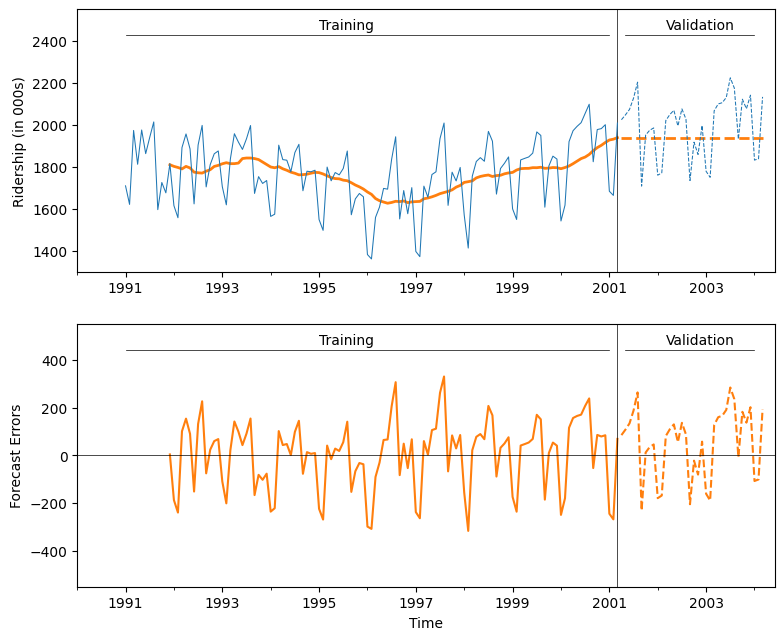

In [5]:
# PRIMA di implementare l'approccio sopra descritto vediamo i RESIDUI (in questo caso del fit con trailing MA):

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

# il plot di prima:
ma_trailing.plot(ax=axes[0], linewidth=2, color='C1')
ma_trailing_pred.plot(ax=axes[0], linewidth=2, color='C1', linestyle='dashed')

# il calcolo dei residui:
residual = train_ts - ma_trailing
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - ma_trailing_pred
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_ts, valid_ts)

plt.show() # il secondo grafico plotta il fit dei residui del primo con trailing MA;
           # l'assunzione (per la regressione) di una loro distribuzione gaussiana con media 0 sembra ragionevole.

Ora la **diagnostica dei residui**.<br>
[Verifica delle assunzioni - fondamentale!](Check_assunzioni.png)

# TSF con trailing MA (in due passi)

In [6]:
# implementiamo ora l'approccio prima descritto.

# 1. costruzione di un modello di regressione con trend quadratico e stagionalità (a passi, come visto nel notebook C.)
ridership_df = tsatools.add_trend(ridership_ts, trend='ct') # solo ct' per ora
ridership_df['Month'] = ridership_df.index.month

# 2. partizionamento dei dati:
train_df = ridership_df[:nTrain]
valid_df = ridership_df[nTrain:]

# 3. fit con un modello di regressione:
formula = 'Ridership ~ trend + np.square(trend) + C(Month)' # ora trend quadratico (e stagionalità)
ridership_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# 4. forecast single-point:
ridership_prediction = ridership_lm_trendseason.predict(valid_df.iloc[0, :]) # subsetting finale del primo mese di validation
                      # --> è la previsione del valore di apr-01 (il primo periodo del validation set) basata
                      #     sulla serie del training set sino a mar-01.
                      #     2004.271 --> 2.004.271 passeggeri previsti (per apr-01)

# 5. applichiamo infine un trailing MA (con w=12 mesi) ai residui (della regressione) degli ultimi 12 mesi del training set
# (cioè da apr-00 a mar-01):
ma_trailing = ridership_lm_trendseason.resid.rolling(12).mean() 

print('Prediction', ridership_prediction[0]) # il valore previsto (con la regressione) per apr-01
print('ma_trailing', ma_trailing[-1])        # l'errore previsto (con trailing MA) per apr-01
# --> cioè, dobbiamo correggere 2004 con 2004+31=2035.
#     abbiamo cioè ottenuto un forecast (di apr-01) migliore (più preciso) di quello fornito dalla sola regressione.
#     infatti, il valore effettivo di apr-01 è 2024!

Prediction 2004.2708927643798
ma_trailing 30.780684624166515


C:\Users\Utente\AppData\Local\Temp\ipykernel_15088\640247769.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Prediction', ridership_prediction[0]) # il valore previsto (con la regressione) per apr-01
C:\Users\Utente\AppData\Local\Temp\ipykernel_15088\640247769.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('ma_trailing', ma_trailing[-1])        # l'errore previsto (con trailing MA) per apr-01


# La scelta di *w*
Sia per la *data visualization* (con uno dei 2 metodi MA) che per TSF (con trailing MA), <u>l'unica scelta</u> che l'utente deve fare è quella del parametro *w*, l'ampiezza della finestra sulla quale fare *averaging*. Qual è il **miglior valore** di *w*?
* come per altri metodi di ML, c'è anche qui un **trade-off** (*bilanciamento*) tra *under-smoothing* e *over-smoothing*;
* per la data visualization (con una finestra centrata), finestre <u>più ampie</u> evidenziano meglio i trend <u>globali</u>, finestre <u>più piccole</u> quelli <u>locali</u>; dunque è utile esplorare differenti valori di w;
* per TSF (con una finestra trailing), la scelta si basa sulla conoscenza del dominio applicativo (es. **la rilevanza dei valori passati** o quanto rapidamente la serie **cambia nel tempo**) --> ad esempio, per serie non-stazionarie, è bene scegliere w non grandi;
* in ogni caso, è utile sperimentare con differenti valori di w;
* e sempre fare attenzione al rischio (concretissimo) di **overfitting** (over-smoothing)!


# Smoothing esponenziale
Un metodo di di forecasting molto diffuso nelle aziende è lo *smoothing esponenziale*.<br>
E' flessibile, facile da implementare, veloce.<br>
Lo smoothing esponenziale **semplice** è simile al moving average perchè fa anch'esso un'operazione di media (*averaging*), ma su **TUTTI** i valori della serie (e non solo su una finestra come MA) ed usando dei **pesi** che in genere premiano i valori più recenti a discapito dei più lontani nel tempo. Cioè i pesi decrescono <u>esponenzialmente</u> nel tempo.<br>
Dunque, il parametro dello smoothing esponenziale sono i pesi (non c'è invece il parametro *w* del MA perchè si considera <u>tutta</u> la serie, seppur in modo appunto differente.)<br> 
In realtà, i pesi sono espressi tramite il parametro **alfa**, che è deciso dall'utente, e che determina la **velocità di learning**. Vedi qui [l'equazione](Exp_smoothing.png).
<br>Alfa vicino ad **1** indica un learning <u>veloce</u>, cioè solo i valori della serie *più recenti* avranno influenza sui forecast, mentre un valore vicino a **0** indica un learning <u>lento</u>, cioè anche i valori *lontani* nel tempo saranno tenuti in conto nel forecast. **In genere si sceglie un valore di alfa intorno a 0.1-0.2** [regola del pollice da sperimentare sulla vostra realtà applicativa con il metodo *trial-and-error*]. Non scegliere mai il **"miglior alfa"** perchè porta di sicuro ad <u>overfitting</u> su nuovi dat
Come per MA, anche lo smoothing esponenziale <u>semplice</u> è adatto solo per serie senza trend e stagionalità. Tuttavia, una tale serie si ottenie facilmente rimuovendo trend e stagionalità dai dati originari (con un qualche metodo) e **POI** applicando lo smoothing esponenziale ai residui, che appunto NON dovrebbero contenere più trend e stagionalità.<br>
i.

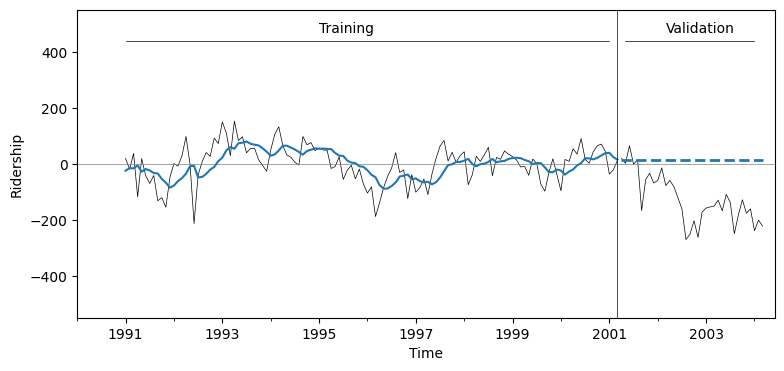

2001-04-01    14.142855
Freq: MS, dtype: float64


In [7]:
# vogliamo prevedere il RESIDUO di apr-01, il primo mese del validation set. [si assume che la serie dei residui NON 
# contenga trend e stagionalità; qui, perchè si usano i residui della regressione solita].
# Dobbiamo applicare exp. smooth. all'intero training set (da gen-91 a mar-01: 123 periodi)
residuals_ts = ridership_lm_trendseason.resid
residuals_pred = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)

fig, ax = plt.subplots(figsize=(9,4))

ridership_lm_trendseason.resid.plot(ax=ax, color='black', linewidth=0.5)
residuals_pred.plot(ax=ax, color='black', linewidth=0.5)
ax.set_ylabel('Ridership')
ax.set_xlabel('Time')
ax.axhline(y=0, xmin=0, xmax=1, color='grey', linewidth=0.5)

# esecuzione dello smoothing esponenziale con alfa = 0.2.
# usiamo il metodo 'ExponentialSmoothing' di 'statsmodels', dove l'argomento 'smoothing_level' rappresenta alfa. 

expSmooth = ExponentialSmoothing(residuals_ts, freq='MS')                             # a. il costruttore
                                   # da DMBA python (p. 463):
                                   # - argomenti 'trend' / 'seasonal' (def.'None') per aggiungere trend / stagionalità 
                                   # - additive o moltiplicative;
                                   # - argomento 'seasonal_periods' per indicare il numero di stagioni;
                                   # - argomento 'smoothing_level' per specificare il valore di alfa;
                                   # - argomento 'smoothing_slope' per specificare il valore di beta;
                                   # - argomento 'smoothing_seasonal' per specificare il valore di gamma;
                                   # - Se questi argomenti NON sono specificati dall'utente, il metodo sceglie valori
                                   #   ottimizzati.
                                   
                                                                      

expSmoothFit = expSmooth.fit(smoothing_level=0.2)                                     # b. il fit

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0') # c. la previsione

singleGraphLayout(ax, [-550, 550], train_df, valid_df)

plt.show()

print(expSmoothFit.forecast(1))  # --> forecast dell'errore (residuo) di apr-01: 14.143 (in migliaia), stabile per tutto
                                 #     il validation set.
                                 # --> Il forecast di apr-01 fornito dalla regressione deve essere corretto con + 14.143.

**Bottom-line** sui metodi di smoothing:
* in questa sezione abbiamo applicato i metodi di smoothing, che si possono applicare solo a serie SENZA trend nè STAGIONALITA' (altrimenti, come visto, forniscono previsioni non affidabili), ai residui della regressione (che appunto avevavo tali caratteristiche);
* in generale, i  metodi di smoothing possono essere utilizzati per TSF di qualsiasi serie, anche di VALORI e non solo di residui) purchè soddisfi le succitate caratteristiche. E ci sono molto serie dati originari di questo tipo. 

**Da qui in poi codice di DMBA NON fatto nel corso.**

In [8]:
# residuals_ts = ridership_lm_trendseason.resid

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

# ridership_lm_trendseason.predict(train_df).plot(ax=axes[0], linewidth=2, color='C1')
# ridership_lm_trendseason.predict(valid_df).plot(ax=axes[0], linewidth=1, color='C1')

# ridership_lm_trendseason.resid.plot(ax=axes[1], color='C1')
# residuals_pred = valid_df.Ridership - ridership_lm_trendseason.predict(valid_df)
# residuals_pred.plot(ax=axes[1], color='C1', linestyle='dashed')


# # run exponential smoothing
# # with smoothing level alpha = 0.2
# expSmooth = ExponentialSmoothing(residuals_ts, freq='MS')
# expSmoothFit = expSmooth.fit(smoothing_level=0.2)
# expSmoothForecast = expSmoothFit.forecast(len(valid_ts))

# expSmoothFit.fittedvalues.plot(ax=axes[1], color='C2')
# expSmoothForecast.plot(ax=axes[1], linewidth=2, color='C2', linestyle='dashed')

# correctedRidership_lm_trendseason = ridership_lm_trendseason.predict(valid_df) - expSmoothForecast
# correctedRidership_lm_trendseason.plot(ax=axes[0], linewidth=0.5, color='C2')


# graphLayout(axes, train_ts, valid_ts)


# plt.show()

# print(expSmoothFit.forecast(1))

In [9]:
# Figure 18.5

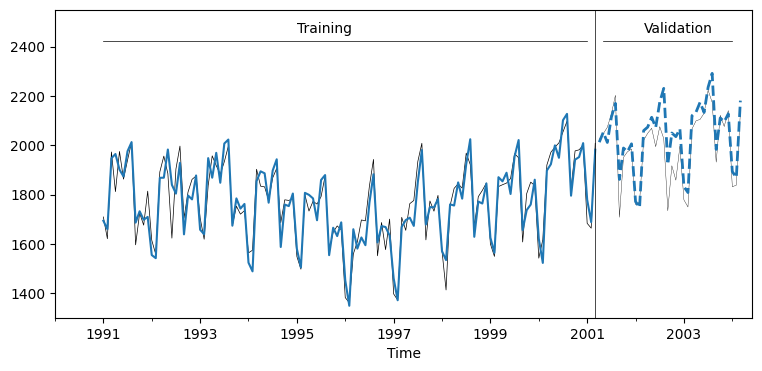

In [10]:
# run exponential smoothing with additive trend and additive seasonal
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal='additive', seasonal_periods=12, freq='MS')
expSmoothFit = expSmooth.fit()

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)

expSmoothFit.fittedvalues.plot(ax=ax)
expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')
singleGraphLayout(ax, [1300, 2550], train_ts, valid_ts)

plt.show()

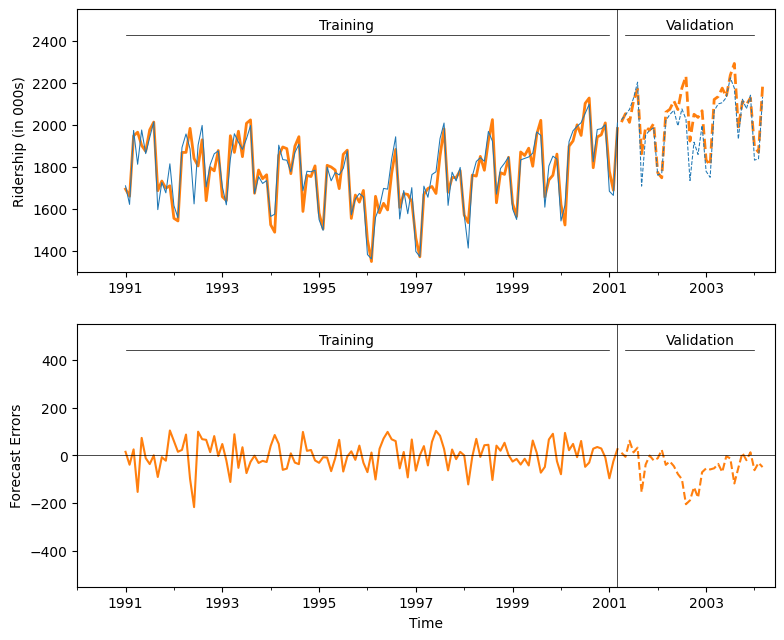

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

expSmoothFit.fittedvalues.plot(ax=axes[0], linewidth=2, color='C1')
expSmoothFit.forecast(len(valid_ts)).plot(ax=axes[0], linewidth=2, color='C1', linestyle='dashed')

residual = train_ts - expSmoothFit.fittedvalues
residual.plot(ax=axes[1], color='C1')
residual = valid_ts - expSmoothFit.forecast(len(valid_ts))
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_ts, valid_ts)

plt.show()

In [12]:
Table 18.2

SyntaxError: invalid syntax (116999374.py, line 1)

In [13]:
expSmoothFit.params

{'smoothing_level': 0.5641935329401964,
 'smoothing_trend': 0.0039077893405662185,
 'smoothing_seasonal': 0.0005060994453987424,
 'damping_trend': nan,
 'initial_level': 1677.021852558779,
 'initial_trend': 0.19821938768344577,
 'initial_seasons': array([ 32.30923383, -10.24612048, 293.96013748, 294.91368035,
        326.80746863, 281.36122053, 392.33191764, 443.45406142,
        122.93665201, 247.42488569, 238.2382331 , 275.18748082]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [14]:
print('AIC: ', expSmoothFit.aic)
print('AICc: ', expSmoothFit.aicc)
print('BIC: ', expSmoothFit.bic)

AIC:  1022.3592535867122
AICc:  1028.9361766636353
BIC:  1067.354203272671
